In [1]:
import os 
os.chdir('../../../../')
print("Current working directory is now: ", os.getcwd())

import pandas as pd 
import numpy as np
import csv
import utils.baseline_functions as base
import stumps
import RiskSLIM as slim

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import roc_auc_score

# restore saved variables
%store -r summary_drug6_KY_interpret

Current working directory is now:  C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test
no stored variable summary_drug6_KY_interpret


C:\Users\binha\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).



### CART & EBM

In [2]:
### load data
data = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/KY data/kentucky_data.csv")
data = data.drop(['fta_risk_score_raw','nca_risk_score_raw','pvf_risk_score_raw', 
                  'fta_calc', 'nca_calc', 'pvf_calc'], axis=1)
x = data.loc[:,:'current_violence']
y = data['recid_drug_six_month'].values

In [3]:
#### CART
depth = [5,6]
cart_summary = base.CART(X=x,
                         Y=y,
                         depth=depth,
                         seed=816)

#### EBM
estimators = [20]
depth = [2]
learning_rate = [0.3]
ebm_summary = base.EBM(X=x,
                       Y=y,
                       learning_rate=learning_rate,
                       depth=depth,
                       estimators=estimators,
                       seed =816)

model_id, score_thresholds 0 {'rank_abs': [1]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'rank_abs': [5]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'rank_abs': [4]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'rank_abs': [0]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'rank_abs': [5]}
get_disparity_predefined_group()


model_id, score_thresholds 0 {'rank_abs': [2]}
get_disparity_predefined_group()


model_id, score_thresholds 0 {'rank_abs': [0]}
get_disparity_predefined_group()


model_id, score_thresholds 0 {'rank_abs': [4]}
get_disparity_predefined_group()


model_id, score_thresholds 0 {'rank_abs': [2]}
get_disparity_predefined_group()


model_id, score_thresholds 0 {'rank_abs': [4]}
get_disparity_predefined_group()


In [4]:
np.mean(cart_summary['holdout_test_auc']), np.mean(cart_summary['auc_diffs'])

(0.7706080870990294, 0.016450211636725574)

In [5]:
np.mean(ebm_summary['holdout_test_auc']), np.mean(ebm_summary['auc_diffs'])

(0.7744094441845822, 0.014594698854934673)

## Lasso Stumps

In [6]:
## load whole data
data = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/KY data/kentucky_stumps.csv")
X_stumps, Y_stumps = data.loc[:,:'current_violence>=1'], data['recid_drug_six_month'].values
Y_stumps[Y_stumps == -1] = 0
cols = X_stumps.columns[3:]

## load train & test data
train_stumps = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/KY data/kentucky_train_stumps.csv")
test_stumps = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/KY data/kentucky_test_stumps.csv")

X_train_stumps, Y_train_stumps = train_stumps.loc[:,:'current_violence>=1'], train_stumps['recid_drug_six_month'].values
X_test_stumps, Y_test_stumps = test_stumps.loc[:,:'current_violence>=1'], test_stumps['recid_drug_six_month'].values

Y_train_stumps[Y_train_stumps == -1] = 0
Y_test_stumps[Y_test_stumps == -1] = 0

#### Nested Cross Validation

In [7]:
stump_summary = stumps.stump_cv(X = X_stumps, 
                                Y = Y_stumps, 
                                columns=cols, 
                                c_grid={'C': [0.007, 0.005, 0.003]}, 
                                seed = 816)

model_id, score_thresholds 0 {'rank_abs': [12598]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'rank_abs': [12419]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'rank_abs': [12653]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'rank_abs': [12578]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'rank_abs': [12752]}
get_disparity_predefined_group()


In [9]:
stump_summary['best_params'], np.mean(stump_summary['holdout_test_auc']), np.mean(stump_summary['auc_diffs'])

({'C': 0.007}, 0.7775529726060678, 0.004313591269232897)

##### Best Stump Model

In [10]:
best_stump_model = stumps.stump_model(X_train_stumps, Y_train_stumps, 
                                      X_test_stumps, Y_test_stumps, 
                                      c=0.003, columns=cols, seed=816)

##### Prediction Table

In [11]:
stumps.stump_table(best_stump_model['coefs'], 
                   best_stump_model['features'], 
                   best_stump_model['intercept'], 
                   best_stump_model['dictionary'])

+-----------------------------------+----------------+
| Features                          | Score          |
|====================================================|
| sex                               | 7.7            |
| age_at_current_charge<=24         | -3.6           |
| age_at_current_charge<=55         | -0.5           |
| p_arrest>=1                       | -52.3          |
| p_arrest>=2                       | 41.8           |
| p_arrest>=3                       | 30.1           |
| p_arrest>=4                       | 21.1           |
| p_arrest>=5                       | 18.6           |
| p_arrest>=6                       | 4.9            |
| p_arrest>=8                       | 5.7            |
| p_charges>=1                      | -50.3          |
| p_charges>=2                      | 5.8            |
| p_felony>=1                       | 34.9           |
| p_misdemeanor>=1                  | 20.5           |
| p_misdemeanor>=2                  | 15.0           |
| p_drug>=

In [12]:
stump_summary = stumps.stump_cv(X = X_stumps, 
                                Y = Y_stumps, 
                                columns=cols, 
                                c_grid={'C': [0.003]}, 
                                seed = 816)

model_id, score_thresholds 0 {'rank_abs': [12453]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'rank_abs': [12556]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'rank_abs': [12466]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'rank_abs': [12650]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'rank_abs': [12679]}
get_disparity_predefined_group()


In [13]:
stump_summary['best_params'], np.mean(stump_summary['holdout_test_auc']), np.mean(stump_summary['auc_diffs'])

({'C': 0.003}, 0.7745588212839373, 0.0029546809203399695)

##### Stumps Visualizations

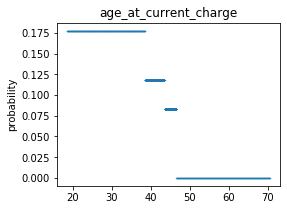

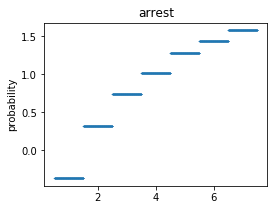

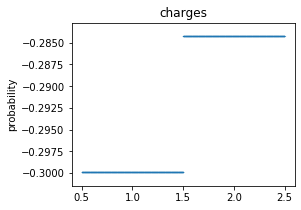

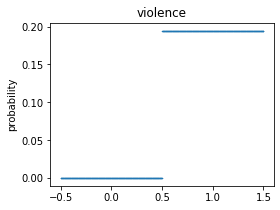

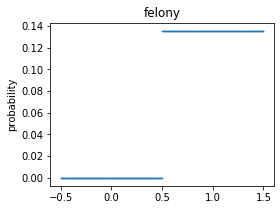

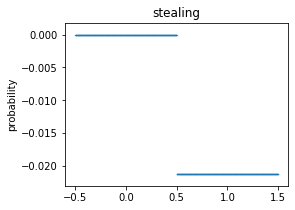

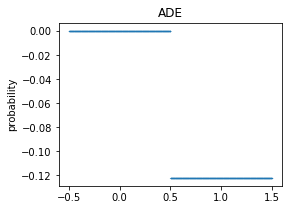

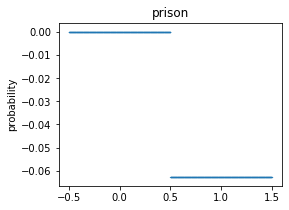

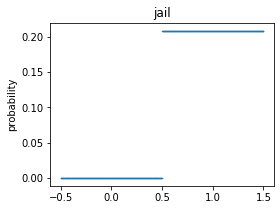

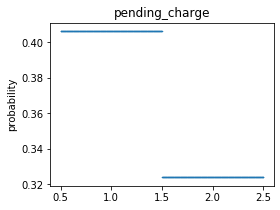

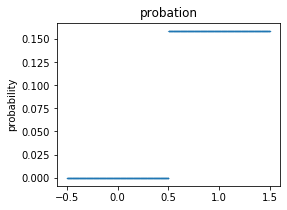

In [20]:
stumps.stump_plots(best_stump_model['features'], best_stump_model['coefs'])

### Arnold PSA

In [14]:
### load data
data = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/KY data/kentucky_data.csv")
X_arnold_raw = data['nca_risk_score_raw'].values
X_arnold_calc = data['nca_calc'].values
Y_arnold = data['recid_drug_six_month'].values

In [15]:
## set up cross validation
cv = KFold(n_splits=5,shuffle=True,random_state=816)
raw_auc = []
calc_auc = []

## raw score
i = 1
for train, test in cv.split(X_arnold_raw, Y_arnold):
    y_pred_raw, y_pred_calc, y_test = X_arnold_raw[test], X_arnold_calc[test], Y_arnold[test]
    raw_auc.append(roc_auc_score(y_test, y_pred_raw))
    calc_auc.append(roc_auc_score(y_test, y_pred_calc))
    i+=1 

## RiskSLIM

In [16]:
## load stumps data
data = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/KY data/kentucky_stumps.csv")
x, y = data.loc[:,:'current_violence>=1'], data['recid_drug_six_month'].values
cols = x.columns[3:]

In [17]:
## train on best param chosen by Lasso Stumps from above
x_train = x.copy().drop(['race', 'person_id', 'screening_date'], axis=1)
lasso = LogisticRegression(class_weight='balanced', solver='liblinear', penalty='l1', C=0.003, random_state=816).fit(x_train,y)
selected_features = cols[lasso.coef_[0] != 0].tolist()
len(selected_features)

30

In [18]:
### Subset features
if 'sex' in selected_features:
    selected_features = ['recid_drug_six_month', 'person_id', 'screening_date', 'race'] + selected_features
    indicator = 1
else:
    selected_features = ['recid_drug_six_month', 'person_id', 'screening_date', 'race', 'sex'] + selected_features
    indicator = 0

sub_data = data[selected_features]
sub_X, sub_Y = sub_data.iloc[:,1:], sub_data.iloc[:,0].values
sub_X.insert(0, '(Intercept)', 1)

In [19]:
riskslim_summary = slim.risk_cv(X=sub_X, 
                                Y=sub_Y, 
                                indicator = indicator,
                                y_label='recid_drug6', 
                                max_coef=20, 
                                max_coef_number=10, 
                                max_runtime=200, 
                                c=1e-5, 
                                seed=816)

setting c0 = 0.0 to ensure that intercept is not penalized
09/11/19 @ 04:13 PM | 1301 rows in lookup table
09/11/19 @ 04:13 PM | ------------------------------------------------------------
09/11/19 @ 04:13 PM | runnning initialization procedure
09/11/19 @ 04:13 PM | ------------------------------------------------------------
09/11/19 @ 04:14 PM | CPA produced 2 cuts
09/11/19 @ 04:14 PM | running naive rounding on 104 solutions
09/11/19 @ 04:14 PM | best objective value: 0.0926
09/11/19 @ 04:14 PM | rounding produced 5 integer solutions
09/11/19 @ 04:14 PM | best objective value is 0.0939
09/11/19 @ 04:14 PM | running sequential rounding on 104 solutions
09/11/19 @ 04:14 PM | best objective value: 0.0926
09/11/19 @ 04:14 PM | sequential rounding produced 3 integer solutions
09/11/19 @ 04:14 PM | best objective value: 0.0939
09/11/19 @ 04:14 PM | polishing 8 solutions
09/11/19 @ 04:14 PM | best objective value: 0.0939
09/11/19 @ 04:14 PM | polishing produced 5 integer solutions
09/11/1

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
09/11/19 @ 04:14 PM | adding 251 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.0939.
Tried aggregator 1 time.
Reduced MIP has 32 rows, 64 columns, and 123 nonzeros.
Reduced MIP has 30 binaries, 32 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.07 ticks)
Probing time = 0.00 sec. (0.02 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variab

 238415 63532        cutoff              0.0939        0.0924  1004363    1.61%           rho_0 U 238415 238414     59
 242102 64739        0.0933     7        0.0939        0.0924  1026028    1.61%           rho_9 D 242102 242100     48
 246183 65734        cutoff              0.0939        0.0924  1042235    1.61%          rho_27 U 246183 246182     81
 250120 66854        0.0924     7        0.0939        0.0924  1059229    1.61%           rho_4 N 250120 238277     73
 254452 68450        cutoff              0.0939        0.0924  1077838    1.61%           rho_0 U 254452 254451     33
 258466 69750        0.0925     4        0.0939        0.0924  1095329    1.61%           rho_4 U 258466  50475     82
Elapsed time = 64.42 sec. (50794.68 ticks, tree = 22.15 MB, solutions = 1)
 262316 71115        0.0925     6        0.0939        0.0924  1112636    1.61%           rho_0 D 262316 262314     60
 266171 72387        0.0930    12        0.0939        0.0924  1130229    1.61%           rh

 696845 197284        0.0928     5        0.0939        0.0924  3121028    1.61%          rho_24 D 696845 696844     49
 710560 202102        0.0925     6        0.0939        0.0924  3183651    1.61%          rho_11 U 710560 710524     72
Elapsed time = 195.78 sec. (168107.53 ticks, tree = 62.04 MB, solutions = 1)
 724420 206034        cutoff              0.0939        0.0924  3253439    1.61%          rho_13 U 724420 724419     52

User cuts applied:  356

Root node processing (before b&c):
  Real time             =    0.14 sec. (1.55 ticks)
Sequential b&c:
  Real time             =  199.88 sec. (172666.31 ticks)
                          ------------
Total (root+branch&cut) =  200.02 sec. (172667.85 ticks)
+----------------------------------------------+------------------+-----------+
| Pr(Y = +1) = 1.0/(1.0 + exp(-(-6 + score))   |                  |           |
| ============================================ | ================ | ========= |
| p_arrest>=4                            

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
09/11/19 @ 04:17 PM | adding 249 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.0951.
Tried aggregator 1 time.
Reduced MIP has 32 rows, 64 columns, and 123 nonzeros.
Reduced MIP has 30 binaries, 32 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (0.07 ticks)
Probing time = 0.00 sec. (0.02 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variab

 179910 64987        0.0941     8        0.0950        0.0934   932564    1.66%           rho_0 D 179910 179909     88
 183225 65882        0.0941     9        0.0950        0.0934   950009    1.66%           rho_0 U 183225 183224    104
 186415 66540        0.0934     9        0.0950        0.0934   968959    1.66%           rho_0 D 186415 186413     18
 189660 67311        0.0934     5        0.0950        0.0934   987361    1.66%           rho_6 D 189660 189659     59
 192902 67927        cutoff              0.0950        0.0934  1005391    1.66%          rho_20 D 192902 192901     28
 196128 68565        0.0944     8        0.0950        0.0934  1022740    1.66%           rho_1 U 196128 196121     64
 199141 69231        0.0943     6        0.0950        0.0934  1039304    1.66%           rho_4 U 199141 199139     84
Elapsed time = 59.27 sec. (50795.53 ticks, tree = 22.21 MB, solutions = 2)
 202190 69842        0.0947     4        0.0950        0.0934  1055166    1.66%          rho

 547610 172026        0.0936    13        0.0950        0.0934  2950148    1.62%           rho_4 D 547610 547609     80
 558810 175449        0.0936    12        0.0950        0.0934  3024339    1.62%           rho_4 D 558810 558809     60
 572182 180763        cutoff              0.0950        0.0934  3091784    1.62%           rho_0 U 572182 572181     34
 583717 184238        0.0934    10        0.0950        0.0934  3157555    1.62%           rho_4 U 583717 571647     46
Elapsed time = 172.38 sec. (168112.96 ticks, tree = 55.76 MB, solutions = 4)
 595610 188177        cutoff              0.0950        0.0934  3231355    1.62%           rho_0 U 595610 595609     78
 607177 191969        0.0936    13        0.0950        0.0934  3304196    1.62%          rho_30 D 607177 607176     60
 618200 195335        0.0941    11        0.0950        0.0934  3375143    1.62%           rho_0 D 618200 618198     59
 628947 198422        0.0941     9        0.0950        0.0934  3448326    1.62%   

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
09/11/19 @ 04:21 PM | adding 249 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.0936.
Tried aggregator 1 time.
Reduced MIP has 32 rows, 64 columns, and 123 nonzeros.
Reduced MIP has 30 binaries, 32 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.07 ticks)
Probing time = 0.00 sec. (0.02 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variab

 227066 88495        cutoff              0.0936        0.0920  1112797    1.67%          rho_29 U 227066 227065     44
 231190 89899        0.0929    10        0.0936        0.0920  1132794    1.67%          rho_29 D 231190 231188     52
 235078 91397        0.0922    10        0.0936        0.0920  1154980    1.67%          rho_15 D 235078 235076     81
 239190 93010        cutoff              0.0936        0.0920  1176167    1.67%          rho_18 D 239190 239189     97
 243200 94499        0.0920     5        0.0936        0.0920  1196861    1.67%          rho_10 D 243200 243199     72
 247132 95632        cutoff              0.0936        0.0920  1216743    1.67%           rho_6 U 247132 247131     65
Elapsed time = 61.80 sec. (50795.62 ticks, tree = 28.44 MB, solutions = 1)
 251095 96822        0.0929     7        0.0936        0.0920  1236712    1.67%          rho_11 D 251095 251094     42
 255322 98332        cutoff              0.0936        0.0920  1256133    1.67%           rh

 685453 237411        cutoff              0.0936        0.0920  3538480    1.67%          rho_29 U 685453 685452     89
 698779 241779        0.0920     1        0.0936        0.0920  3615644    1.67%           rho_5 U 698779 698621     48
Elapsed time = 180.30 sec. (168108.84 ticks, tree = 73.97 MB, solutions = 1)
 711452 245071        cutoff              0.0936        0.0920  3684588    1.67%           rho_0 U 711452 711451     59
 724249 248432        0.0933    10        0.0936        0.0920  3752778    1.67%           rho_4 D 724249 724247     68
 735950 252468        0.0932     9        0.0936        0.0920  3831876    1.67%           rho_8 U 735950 735949     76

User cuts applied:  370

Root node processing (before b&c):
  Real time             =    0.20 sec. (1.54 ticks)
Sequential b&c:
  Real time             =  199.81 sec. (181483.31 ticks)
                          ------------
Total (root+branch&cut) =  200.02 sec. (181484.85 ticks)
+----------------------------------------

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
09/11/19 @ 04:24 PM | adding 249 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.0941.
Tried aggregator 1 time.
Reduced MIP has 32 rows, 64 columns, and 123 nonzeros.
Reduced MIP has 30 binaries, 32 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.07 ticks)
Probing time = 0.00 sec. (0.02 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variab

 211873 66080        0.0926    11        0.0941        0.0925  1081509    1.68%           rho_0 D 211873 211871     85
 215748 67243        cutoff              0.0941        0.0925  1101090    1.68%          rho_13 U 215748 215746     44
 219395 67959        cutoff              0.0941        0.0925  1121330    1.68%          rho_21 U 219395    348     17
 223287 69789        cutoff              0.0941        0.0925  1141224    1.68%           rho_0 U 223287 223286     45
 227158 70927        0.0929     9        0.0941        0.0925  1161305    1.68%           rho_1 D 227158 227157     88
 230836 71816        0.0930     8        0.0941        0.0925  1182223    1.68%           rho_0 D 230836 230834     89
Elapsed time = 59.64 sec. (50794.44 ticks, tree = 22.31 MB, solutions = 1)
 234552 72866        0.0932     7        0.0941        0.0925  1203250    1.68%           rho_0 D 234552 234551     50
 238336 73636        cutoff              0.0941        0.0925  1220805    1.68%          rho

 603853 188751        0.0935     7        0.0941        0.0925  3416560    1.68%          rho_18 U 603853 603852     63
 615050 192958        0.0938    11        0.0941        0.0925  3491157    1.68%           rho_0 U 615050 615048     40
Elapsed time = 136.78 sec. (168110.91 ticks, tree = 59.22 MB, solutions = 1)
 625340 197512        0.0925    17        0.0941        0.0925  3573001    1.68%           rho_4 D 625340 625339     38
 636200 202089        0.0927    10        0.0941        0.0925  3652832    1.68%           rho_3 D 636200 636199     53
 646870 205578        0.0939    11        0.0941        0.0925  3726036    1.68%          rho_13 D 646870 646868     82
 657298 210146        cutoff              0.0941        0.0925  3804738    1.68%          rho_24 U 657298 657297     63
 667755 214615        0.0936    13        0.0941        0.0925  3882591    1.68%          rho_19 U 667755 667754     82
 679000 218670        0.0926    20        0.0941        0.0925  3957480    1.68%   

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
09/11/19 @ 04:28 PM | adding 250 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.0937.
Tried aggregator 1 time.
Reduced MIP has 32 rows, 64 columns, and 123 nonzeros.
Reduced MIP has 30 binaries, 32 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.07 ticks)
Probing time = 0.00 sec. (0.02 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variab

 206749 66183        0.0925    12        0.0937        0.0921  1022030    1.69%           rho_0 D 206749 206747     97
 210276 67611        0.0921     4        0.0937        0.0921  1038038    1.69%           rho_4 N 210276 210275     51
 213837 68966        cutoff              0.0937        0.0921  1054460    1.69%          rho_13 U 213837 213835     54
 217569 70016        0.0932     7        0.0937        0.0921  1075195    1.69%          rho_15 D 217569 217568     84
 221355 71189        0.0925     7        0.0937        0.0921  1094501    1.69%           rho_3 D 221355 221353     62
 225050 72289        0.0921     7        0.0937        0.0921  1114689    1.69%          rho_12 U 225050 225048     21
 228811 73571        0.0931    11        0.0937        0.0921  1136975    1.69%           rho_0 D 228811 228809     74
Elapsed time = 31.39 sec. (50793.05 ticks, tree = 23.20 MB, solutions = 2)
 232288 74354        0.0936    10        0.0937        0.0921  1157553    1.69%          rho

 620947 203293        cutoff              0.0937        0.0921  3304633    1.69%           rho_3 U 620947 620946     82
 633826 207930        0.0922    17        0.0937        0.0921  3373322    1.69%           rho_3 D 633826 633825     27
 646086 211959        0.0934     2        0.0937        0.0921  3450476    1.69%           rho_4 U 646086 646085     65
Elapsed time = 90.67 sec. (168107.30 ticks, tree = 64.56 MB, solutions = 2)
 658748 216169        cutoff              0.0937        0.0921  3531381    1.69%           rho_0 U 658748 658747     87
 671204 220155        0.0936     5        0.0937        0.0921  3604317    1.69%          rho_30 D 671204 671202     54
 684197 224616        0.0928     9        0.0937        0.0921  3674644    1.69%          rho_27 D 684197 684195     49
 699080 228291        0.0927     8        0.0937        0.0921  3729657    1.69%          rho_11 N 699080 699079     45
 711145 232365        0.0924     8        0.0937        0.0921  3800862    1.69%    

 1387000 435971        0.0922    10        0.0937        0.0921  7797956    1.69%          rho_15 D 1387000 1386999     41
 1398115 438645        cutoff              0.0937        0.0921  7866118    1.69%           rho_8 U 1398115 1398113     67

User cuts applied:  406

Root node processing (before b&c):
  Real time             =    0.09 sec. (1.55 ticks)
Sequential b&c:
  Real time             =  199.92 sec. (406112.37 ticks)
                          ------------
Total (root+branch&cut) =  200.02 sec. (406113.92 ticks)
+----------------------------------------------+------------------+-----------+
| Pr(Y = +1) = 1.0/(1.0 + exp(-(-5 + score))   |                  |           |
| ============================================ | ================ | ========= |
| p_arrest>=4                                  |         1 points |   + ..... |
| p_drug>=1                                    |         1 points |   + ..... |
| p_pending_charge>=1                          |         1 points |   + 

In [20]:
np.mean(riskslim_summary['train_auc']), np.mean(riskslim_summary['test_auc'])

(0.7380585493133993, 0.7340316561500986)

### Results

In [21]:
#### save results
summary_drug6_KY_interpret = {"CART": cart_summary,
                                   "EBM": ebm_summary, 
                                   'Lasso Stumps': stump_summary, 
                                   'RiskSLIM': riskslim_summary, 
                                   'Arnold PSA Raw': raw_auc, 
                                   'Arnold PSA': calc_auc}
%store summary_drug6_KY_interpret

Stored 'summary_drug6_KY_interpret' (dict)


In [22]:
results = [["CART", np.mean(cart_summary['holdout_test_auc']), np.mean(cart_summary['auc_diffs'])],
           ["EBM", np.mean(ebm_summary['holdout_test_auc']), np.mean(ebm_summary['auc_diffs'])], 
           ["Lasso Stumps", np.mean(stump_summary['holdout_test_auc']), np.mean(stump_summary['auc_diffs'])],
           ['RiskSLIM', np.mean(riskslim_summary['test_auc'])],
           ['Arnold PSA Raw', round(np.mean(raw_auc), 3)], 
           ['Arnold PSA', round(np.mean(calc_auc), 3)]]
results

[['CART', 0.7706080870990294, 0.016450211636725574],
 ['EBM', 0.7744094441845822, 0.014594698854934673],
 ['Lasso Stumps', 0.7745588212839373, 0.0029546809203399695],
 ['RiskSLIM', 0.7340316561500986],
 ['Arnold PSA Raw', 0.672],
 ['Arnold PSA', 0.671]]

In [23]:
auc = [np.mean(cart_summary['holdout_test_auc']), 
       np.mean(ebm_summary['holdout_test_auc']), 
       np.mean(stump_summary['holdout_test_auc']), 
       np.mean(riskslim_summary['test_auc'])]

In [24]:
path = "C:/Users/binha/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/KY Results/Models/Six Month/"
results = [["Drug", np.str((round(np.mean(cart_summary['holdout_test_auc']), 3))) + " (" + np.str(round(np.std(cart_summary['holdout_test_auc']), 3)) + ")", 
            np.str(round(np.mean(ebm_summary['holdout_test_auc']),3)) + " (" + np.str(round(np.std(ebm_summary['holdout_test_auc']), 3)) + ")", 
            np.str(round(np.mean(stump_summary['holdout_test_auc']),3)) + " (" + np.str(round(np.std(stump_summary['holdout_test_auc']), 3)) + ")",             
            np.str(round(np.mean(riskslim_summary['test_auc']),3)) + " (" + np.str(round(np.std(riskslim_summary['test_auc']), 3)) + ")", 
            round(np.max(auc) - np.min(auc), 3),
            np.str(round(np.mean(raw_auc), 3)) + " (" + np.str(round(np.std(raw_auc),3)) + ")", 
            np.str(round(np.mean(calc_auc), 3)) + " (" + np.str(round(np.std(calc_auc),3)) + ")"]]
with open(path + 'Interpretable Models Summary.csv', 'a') as writeFile:
    writer = csv.writer(writeFile)
    writer.writerows(results)